In [1]:
import torch
from torch import nn
from d2l import torch as d2l
import time
from ptflops import get_model_complexity_info

# Problem 1

### Part A)

In [2]:
bs = 32
ns = 9
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
data = d2l.MTFraEng(batch_size=bs, num_steps=ns, num_train=512, num_val=128)

In [3]:
def init_seq2seq(module):  #@save
    """Initialize weights for Seq2Seq."""
    if type(module) == nn.Linear:
         nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.GRU:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])

In [4]:
class Seq2SeqDecoder(d2l.Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size+num_hiddens, num_hiddens,
                           num_layers, dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(init_seq2seq)

    def init_state(self, enc_all_outputs, *args):
        return enc_all_outputs

    def forward(self, X, state):
        # X shape: (batch_size, num_steps)
        # embs shape: (num_steps, batch_size, embed_size)
        embs = self.embedding(X.t().type(torch.int32))
        enc_output, hidden_state = state
        # context shape: (batch_size, num_hiddens)
        context = enc_output[-1]
        # Broadcast context to (num_steps, batch_size, num_hiddens)
        context = context.repeat(embs.shape[0], 1, 1)
        # Concat at the feature dimension
        embs_and_context = torch.cat((embs, context), -1)
        outputs, hidden_state = self.rnn(embs_and_context, hidden_state)
        outputs = self.dense(outputs).swapaxes(0, 1)
        # outputs shape: (batch_size, num_steps, vocab_size)
        # hidden_state shape: (num_layers, batch_size, num_hiddens)
        return outputs, [enc_output, hidden_state]

In [5]:
def train_encdec(embed_size=256, num_hiddens=256, num_layers=2, dropout=0.2):
    engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
    fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
    toc = time.perf_counter()
    encoder = d2l.Seq2SeqEncoder(
        len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
    decoder = Seq2SeqDecoder(
        len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
    model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'], lr=0.005)
    trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
    trainer.fit(model, data)
    tic = time.perf_counter()
    total_time = round(tic-toc, 5)
    print(f"Total Training Time : {total_time} s\nEstimated Average Training Time per Epoch : {round(total_time/30, 5)} s")
    preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
    for en, fr, p in zip(engs, fras, preds):
        translation = []
        for token in data.tgt_vocab.to_tokens(p):
            if token == '<eos>':
                break
            translation.append(token)
        print(f'{en} => {translation}, bleu,'
              f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')    
    return model

In [6]:
layers = [1, 2, 3]
embedding = [128, 256]
hiddens = [128, 256]

Total Training Time : 27.05219 s
Estimated Average Training Time per Epoch : 0.90174 s
go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['venez', '<unk>', '.'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


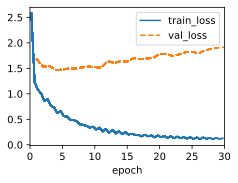

In [7]:
encdec_1 = train_encdec(embedding[0], hiddens[0], layers[0])

Total Training Time : 36.54909 s
Estimated Average Training Time per Epoch : 1.2183 s
go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['je', 'suis', 'calme', '.'], bleu,0.537
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


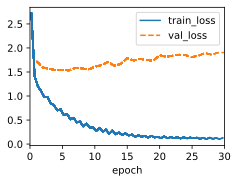

In [8]:
encdec_2 = train_encdec(embedding[0], hiddens[0], layers[1])

Total Training Time : 46.49739 s
Estimated Average Training Time per Epoch : 1.54991 s
go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['il', 'court', '.'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


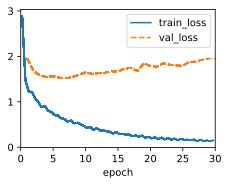

In [9]:
encdec_3 = train_encdec(embedding[0], hiddens[0], layers[2])

Total Training Time : 42.04985 s
Estimated Average Training Time per Epoch : 1.40166 s
go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['il', 'court', '.'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


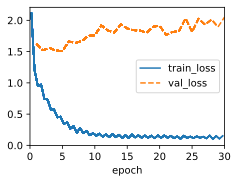

In [10]:
encdec_4 = train_encdec(embedding[0], hiddens[1], layers[0])

Total Training Time : 57.73638 s
Estimated Average Training Time per Epoch : 1.92455 s
go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['il', 'est', 'mouillé', '.'], bleu,0.658
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


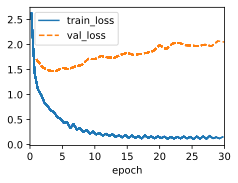

In [11]:
encdec_5 = train_encdec(embedding[0], hiddens[1], layers[1])

Total Training Time : 78.44506 s
Estimated Average Training Time per Epoch : 2.61484 s
go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['il', 'est', 'mouillé', '.'], bleu,0.658
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


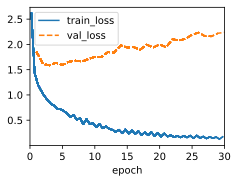

In [12]:
encdec_6 = train_encdec(embedding[0], hiddens[1], layers[2])

Total Training Time : 32.12674 s
Estimated Average Training Time per Epoch : 1.07089 s
go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['il', 'est', 'mouillé', '.'], bleu,0.658
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


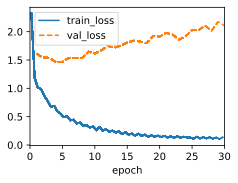

In [13]:
encdec_7 = train_encdec(embedding[1], hiddens[0], layers[0])

Total Training Time : 39.11131 s
Estimated Average Training Time per Epoch : 1.30371 s
go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['il', 'est', 'mouillé', '.'], bleu,0.658
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


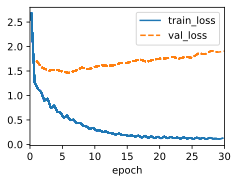

In [14]:
encdec_8 = train_encdec(embedding[1], hiddens[0], layers[1])

Total Training Time : 50.53455 s
Estimated Average Training Time per Epoch : 1.68449 s
go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['elle', 'est', '<unk>', '.'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


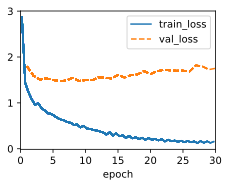

In [15]:
encdec_9 = train_encdec(embedding[1], hiddens[0], layers[2])

Total Training Time : 54.37041 s
Estimated Average Training Time per Epoch : 1.81235 s
go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['<unk>', '.'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


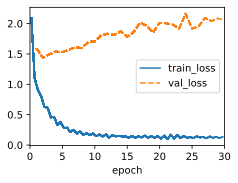

In [16]:
encdec_10 = train_encdec(embedding[1], hiddens[1], layers[0])

Total Training Time : 55.52804 s
Estimated Average Training Time per Epoch : 1.85093 s
go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['je', 'sais', '.'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


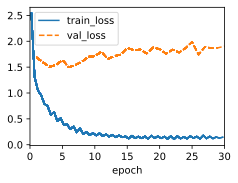

In [17]:
encdec_11 = train_encdec(embedding[1], hiddens[1], layers[1])

Total Training Time : 78.93496 s
Estimated Average Training Time per Epoch : 2.63117 s
go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['je', "l'ai", '.'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


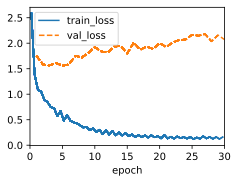

In [18]:
encdec_12 = train_encdec(embedding[1], hiddens[1], layers[2])

### Part B)

In [19]:
class Seq2SeqEncoder_2(d2l.Encoder):
    """The RNN encoder for sequence to sequence learning.

    Defined in :numref:`sec_seq2seq`"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size, num_hiddens, num_layers, dropout)
        self.apply(init_seq2seq)

    def forward(self, X, *args):
        # X shape: (batch_size, num_steps)
        embs = self.embedding(d2l.astype(d2l.transpose(X), d2l.int64))
        # embs shape: (num_steps, batch_size, embed_size)
        outputs, state = self.rnn(embs)
        # outputs shape: (num_steps, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens)
        return outputs, state[-2:][:][:]

Total Training Time : 68.38796 s
Estimated Average Training Time per Epoch : 2.2796 s
go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['il', 'court', '.'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


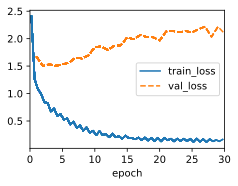

In [80]:
toc = time.perf_counter()
encoder = Seq2SeqEncoder_2(len(data.src_vocab), 256, 256, 3, 0.2)
decoder = Seq2SeqDecoder(len(data.tgt_vocab), 256, 256, 2, 0.2)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'], lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)
tic = time.perf_counter()
total_time = round(tic-toc, 5)
print(f"Total Training Time : {total_time} s\nEstimated Average Training Time per Epoch : {round(total_time/30, 5)} s")
preds, _ = model.predict_step(
data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')

### Part C)

In [21]:
class LSTM(d2l.RNN):  #@save
    """The multi-layer LSTM model."""
    def __init__(self, num_inputs, num_hiddens, num_layers=1, dropout=0):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.LSTM(num_inputs, num_hiddens, num_layers, dropout=dropout)

In [22]:
class Seq2SeqEncoder_LSTM(d2l.Encoder):
    """The RNN encoder for sequence to sequence learning.

    Defined in :numref:`sec_seq2seq`"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = LSTM(embed_size, num_hiddens, num_layers, dropout)
        self.apply(init_seq2seq)

    def forward(self, X, *args):
        # X shape: (batch_size, num_steps)
        embs = self.embedding(d2l.astype(d2l.transpose(X), d2l.int64))
        # embs shape: (num_steps, batch_size, embed_size)
        outputs, state = self.rnn(embs)
        # outputs shape: (num_steps, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens)
        return outputs, state

In [23]:
class Seq2SeqDecoder_LSTM(d2l.Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = LSTM(embed_size+num_hiddens, num_hiddens,
                           num_layers, dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(init_seq2seq)

    def init_state(self, enc_all_outputs, *args):
        return enc_all_outputs

    def forward(self, X, state):
        # X shape: (batch_size, num_steps)
        # embs shape: (num_steps, batch_size, embed_size)
        embs = self.embedding(X.t().type(torch.int32))
        enc_output, hidden_state = state
        # context shape: (batch_size, num_hiddens)
        context = enc_output[-1]
        # Broadcast context to (num_steps, batch_size, num_hiddens)
        context = context.repeat(embs.shape[0], 1, 1)
        # Concat at the feature dimension
        embs_and_context = torch.cat((embs, context), -1)
        outputs, hidden_state = self.rnn(embs_and_context, hidden_state)
        outputs = self.dense(outputs).swapaxes(0, 1)
        # outputs shape: (batch_size, num_steps, vocab_size)
        # hidden_state shape: (num_layers, batch_size, num_hiddens)
        return outputs, [enc_output, hidden_state]

Total Training Time : 77.27733 s
Estimated Average Training Time per Epoch : 2.57591 s
go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['<unk>', 'ceci', '.'], bleu,0.000
i'm home . => ['je', 'suis', '<unk>', '.'], bleu,0.512


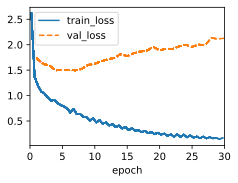

In [81]:
toc = time.perf_counter()
encoder = Seq2SeqEncoder_LSTM(len(data.src_vocab), 256, 256, 2, 0.2)
decoder = Seq2SeqDecoder_LSTM(len(data.tgt_vocab), 256, 256, 2, 0.2)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'], lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)
tic = time.perf_counter()
total_time = round(tic-toc, 5)
print(f"Total Training Time : {total_time} s\nEstimated Average Training Time per Epoch : {round(total_time/30, 5)} s")
preds, _ = model.predict_step(
data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')

# Problem 2

### Part A)

In [39]:
class EncoderDecoder(d2l.Classifier):
    """The base class for the encoder-decoder architecture.

    Defined in :numref:`sec_encoder-decoder`"""
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_all_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_all_outputs, *args)
        # Return decoder output only
        return self.decoder(dec_X, dec_state)[0]


    def predict_step(self, batch, device, num_steps,
                     save_attention_weights=False):
        """Defined in :numref:`sec_seq2seq_training`"""
        batch = [d2l.to(a, device) for a in batch]
        src, tgt, src_valid_len, _ = batch
        enc_all_outputs = self.encoder(src, src_valid_len)
        dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)
        outputs, attention_weights = [d2l.expand_dims(tgt[:, 0], 1), ], []
        for _ in range(num_steps):
            Y, dec_state = self.decoder(outputs[-1], dec_state)
            outputs.append(d2l.argmax(Y, 2))
            # Save attention weights (to be covered later)
            if save_attention_weights:
                attention_weights.append(self.decoder.attention_weights)
        return d2l.concat(outputs[1:], 1), attention_weights

In [63]:
class Seq2SeqAttentionDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.attention = d2l.AdditiveAttention(num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers,
            dropout=dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(d2l.init_seq2seq)

    def init_state(self, enc_outputs, enc_valid_lens):
        # Shape of outputs: (num_steps, batch_size, num_hiddens).
        # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # Shape of enc_outputs: (batch_size, num_steps, num_hiddens).
        # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # Shape of the output X: (num_steps, batch_size, embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # Shape of query: (batch_size, 1, num_hiddens)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # Shape of context: (batch_size, 1, num_hiddens)
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)
            # Concatenate on the feature dimension
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # Reshape x as (1, batch_size, embed_size + num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # After fully connected layer transformation, shape of outputs:
        # (num_steps, batch_size, vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                                          enc_valid_lens]

In [75]:
def train_enc_attdec(embed_size=256, num_hiddens=256, num_layers=2, dropout=0.2):
    engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
    fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
    toc = time.perf_counter()
    encoder = d2l.Seq2SeqEncoder(
        len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
    decoder = Seq2SeqAttentionDecoder(
        len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
    model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'], lr=0.005)
    trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
    trainer.fit(model, data)
    tic = time.perf_counter()
    total_time = round(tic-toc, 5)
    print(f"Total Training Time : {total_time} s\nEstimated Average Training Time per Epoch : {round(total_time/30, 5)} s")
    
    preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
    for en, fr, p in zip(engs, fras, preds):
        translation = []
        for token in data.tgt_vocab.to_tokens(p):
            if token == '<eos>':
                break
            translation.append(token)
        print(f'{en} => {translation}, bleu,'
              f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')
    
#     _, dec_attention_weights = model.predict_step(data.build([engs[-1]], [fras[-1]]), d2l.try_gpu(), data.num_steps, True)
#     attention_weights = torch.cat([step[0][0][0] for step in dec_attention_weights], 0)
#     attention_weights = attention_weights.reshape((1, 1, -1, data.num_steps))
#     # Plus one to include the end-of-sequence token
#     d2l.show_heatmaps(
#         attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
#         xlabel='Key positions', ylabel='Query positions')
    
    return model

Total Training Time : 68.56555 s
Estimated Average Training Time per Epoch : 2.28552 s
go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['soyez', 'calme', '.'], bleu,0.492
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


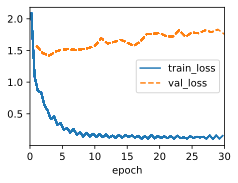

In [85]:
model2_1 = train_enc_attdec(num_layers=1)

Total Training Time : 85.56423 s
Estimated Average Training Time per Epoch : 2.85214 s
go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['soyez', 'calmes', '!'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


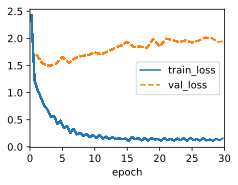

In [82]:
model2_2 = train_enc_attdec(num_layers=2)

Total Training Time : 112.20182 s
Estimated Average Training Time per Epoch : 3.74006 s
go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['il', 'est', 'mouillé', '.'], bleu,0.658
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


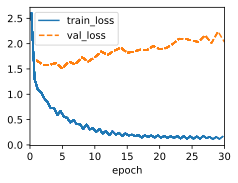

In [83]:
model2_3 = train_enc_attdec(num_layers=3)

Total Training Time : 128.83769 s
Estimated Average Training Time per Epoch : 4.29459 s
go . => ['pars', '!'], bleu,0.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['<unk>', '.'], bleu,0.000
i'm home . => ['je', 'suis', 'porte', 'bien', '.'], bleu,0.548


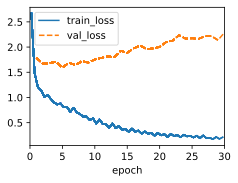

In [84]:
model2_4 = train_enc_attdec(num_layers=4)

### Part B)

In [31]:
class AdditiveAttention(nn.Module):  #@save
    """Additive attention."""
    def __init__(self, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.LazyLinear(num_hiddens, bias=False)
        self.W_q = nn.LazyLinear(num_hiddens, bias=False)
        self.w_v = nn.LazyLinear(1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # After dimension expansion, shape of queries: (batch_size, no. of
        # queries, 1, num_hiddens) and shape of keys: (batch_size, 1, no. of
        # key-value pairs, num_hiddens). Sum them up with broadcasting
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # There is only one output of self.w_v, so we remove the last
        # one-dimensional entry from the shape. Shape of scores: (batch_size,
        # no. of queries, no. of key-value pairs)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # Shape of values: (batch_size, no. of key-value pairs, value
        # dimension)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [46]:
class Seq2SeqAttentionEncoder_LSTM(d2l.Encoder):
    """The RNN encoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = LSTM(embed_size, num_hiddens, num_layers, dropout)
        self.apply(init_seq2seq)

    def forward(self, X, *args):
        # X shape: (batch_size, num_steps)
        embs = self.embedding(X.t().type(torch.int64))
        # embs shape: (num_steps, batch_size, embed_size)
        outputs, state = self.rnn(embs)
        # outputs shape: (num_steps, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens)
        return outputs, state

In [62]:
class Seq2SeqAttentionDecoder_LSTM(d2l.AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.attention = d2l.AdditiveAttention(num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size + num_hiddens, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(d2l.init_seq2seq)

    def init_state(self, enc_outputs, enc_valid_lens):
        # Shape of outputs: (num_steps, batch_size, num_hiddens).
        # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # Shape of enc_outputs: (batch_size, num_steps, num_hiddens).
        # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
        enc_outputs, hidden_state = state
        
        #enc_outputs, hidden_state, enc_valid_lens = state
        
        # Shape of the output X: (num_steps, batch_size, embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # Shape of query: (batch_size, 1, num_hiddens)
            query = torch.unsqueeze(hidden_state[-1].squeeze(0), dim=1)
            # Shape of context: (batch_size, 1, num_hiddens)
            context = self.attention(query, enc_outputs, enc_outputs, enc_valid_lens)
            # Concatenate on the feature dimension
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            print(x)
            # Reshape x as (1, batch_size, embed_size + num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # After fully connected layer transformation, shape of outputs:
        # (num_steps, batch_size, vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                                          enc_valid_lens]

In [49]:
def train_enc_attdec_lstm(embed_size=256, num_hiddens=256, num_layers=2, dropout=0.2):
    encoder = Seq2SeqAttentionEncoder_LSTM(len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
    decoder = Seq2SeqAttentionDecoder_LSTM(len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
    print(encoder, "\n\n", decoder)
    model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'], lr=0.005)
    trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
    trainer.fit(model, data)

In [52]:
model3_1 = train_enc_attdec_lstm(num_layers=1)

Seq2SeqAttentionEncoder_LSTM(
  (embedding): Embedding(194, 256)
  (rnn): LSTM(
    (rnn): LSTM(256, 256, dropout=0.2)
  )
) 

 Seq2SeqAttentionDecoder_LSTM(
  (attention): AdditiveAttention(
    (W_k): LazyLinear(in_features=0, out_features=256, bias=False)
    (W_q): LazyLinear(in_features=0, out_features=256, bias=False)
    (w_v): LazyLinear(in_features=0, out_features=1, bias=False)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (embedding): Embedding(214, 256)
  (rnn): LSTM(512, 256, dropout=0.2)
  (dense): LazyLinear(in_features=0, out_features=214, bias=True)
)


ValueError: too many values to unpack (expected 2)

In [ ]:
model3_2 = train_enc_attdec_lstm(num_layers=2)

In [ ]:
model3_3 = train_enc_attdec_lstm(num_layers=3)

In [ ]:
model3_4 = train_enc_attdec_lstm(num_layers=4)